In [7]:
from keras.preprocessing.text import Tokenizer
from pickle import dump

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


In [11]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('model-ep002-loss3.707-val_loss3.869.h5')
# load and prepare the photograph
photo = extract_features('dogo.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)

startseq dog is running through the grass endseq


startseq dog is running through the grass endseq


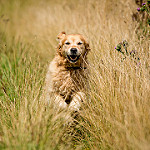

In [14]:
# picture from flickr
# source: https://www.flickr.com/photos/cliffkinch/25082647218/in/photolist-Edt89N-27zySxp-27HihJd-XzLCrK-Z5Z2hg-27KLYF1-G2Z3Gk-211rM9C-GErdQ9-GKFH1t-22KabRS-ZD1drF-27kKVcd-EUwRCE-24AoCEN-aigtcQ-27ZS1Rs-8qXSTP-ZfWfeo-24AoCuC-Kb1tDn-XzLCpR-YLD3v5-25tLfvC-HpJ6Uo-275mtZM-YRxVLU-TjFi1T-25zE7KJ-a1Xtpq-bAkJeJ-oc6ihM-YdQoz6-YdQomv-25u7WZ3-26N2Pmf-HzHUmd-8injVj-JXcCH8-6p9pft-Zz36X8-bCEstU-qDnA7F-oC7xdL-gbEEr8-7GKKTK-26YswW2-86P58b-8gFkyP-292C7e9
from IPython.display import Image
print(description)
Image(filename= 'dogo.jpg', width = 200, height= 200)

startseq dog is running through the grass endseq


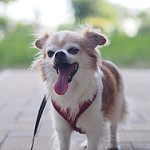

In [16]:
# Dog picture from flickr
#  source: https://www.flickr.com/photos/-chihuahua-/43516440822/in/photolist-29gSSnY-29ip8Ls-29hzhP3-LxKyT9-KGwyCP-MfbvfN-KEhGqx-KF2jS6-26b7bFU-29isDTf-KGUi62-28iim4A-27HDFRL-28hHkrm-LBuJkm-281wiKp-KCUrzv-26b79tY-KuujVp-291syuR-KDuEBz-268PVnb-MbnuTh-29hy1Q1-29hhknd-28JdcL1-28yhR8Y-27wwFt2-25Zznmd-Ks6SMZ-29eMyAC-269vmVY-May9ah-KkEu7z-269jTt3-29e91pY-28RGnw5-26CoV4m-27LyScN-KCXQwM-27MyhSB-Kh5ixe-Kfts1n-LNoNSo-28P9Ru4-28gjzhQ-269v8wJ-28VdG35-28W2MR4-KuukAT
photo = extract_features('dog.jpg')
description = generate_desc(model, tokenizer, photo, max_length)
print(description)
Image(filename= 'dog.jpg', width = 200, height= 200)

startseq man in red shirt is riding bicycle on the street endseq


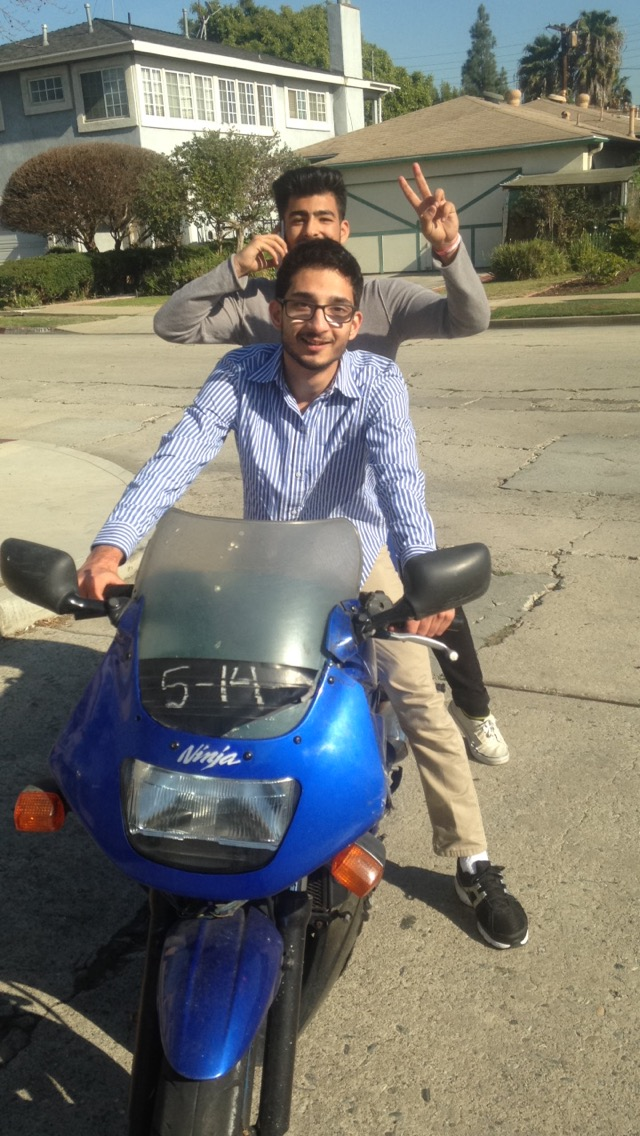

In [17]:
# Mobile picture
photo = extract_features('bike.jpg')
description = generate_desc(model, tokenizer, photo, max_length)
print(description)
Image(filename= 'bike.jpg', width = 200, height= 200)